In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Q1

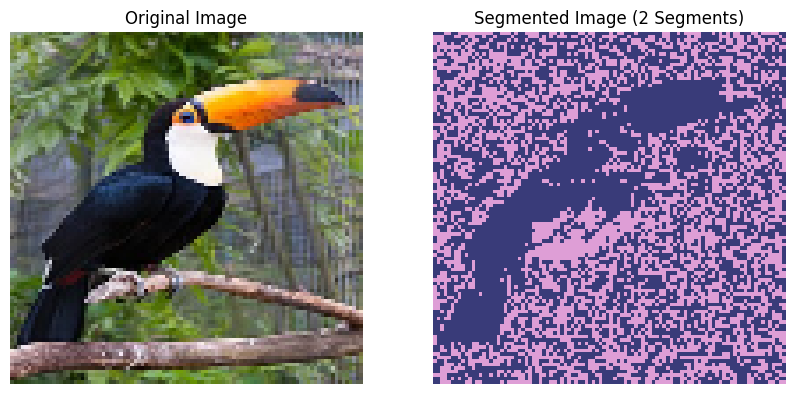

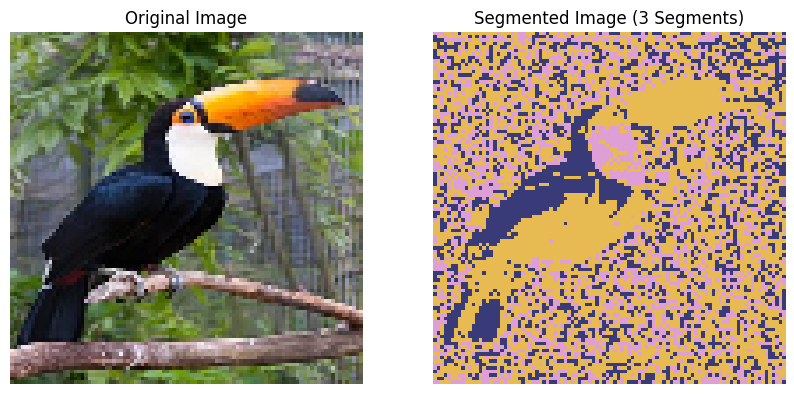

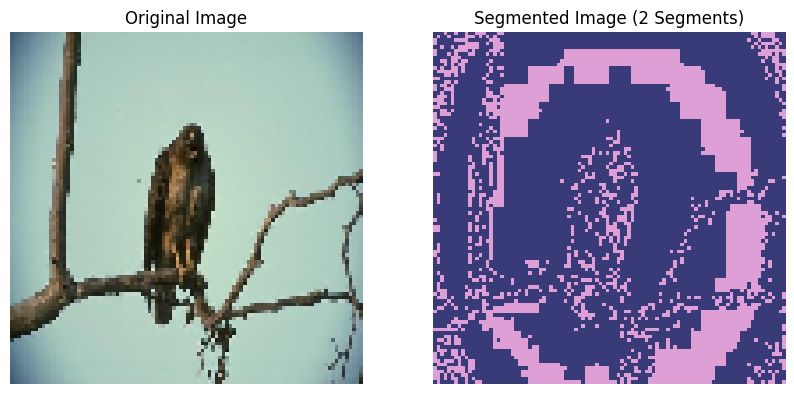

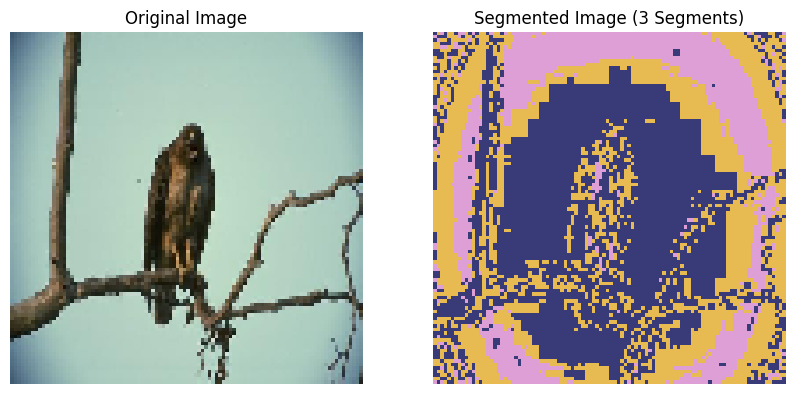

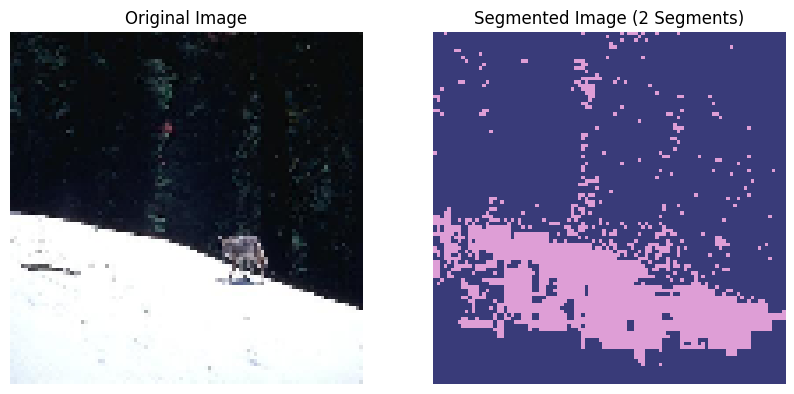

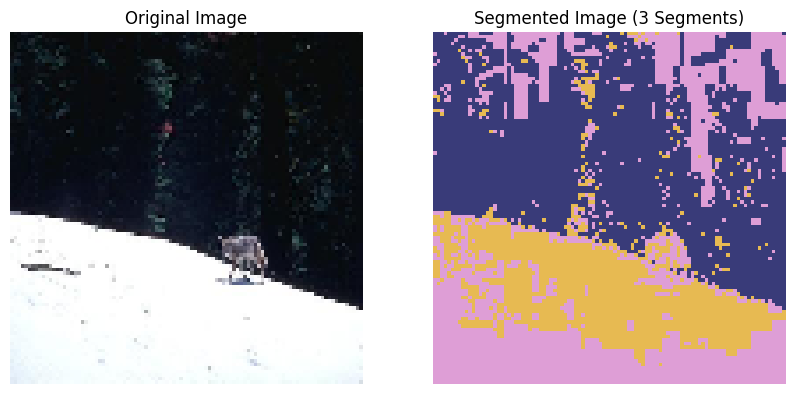

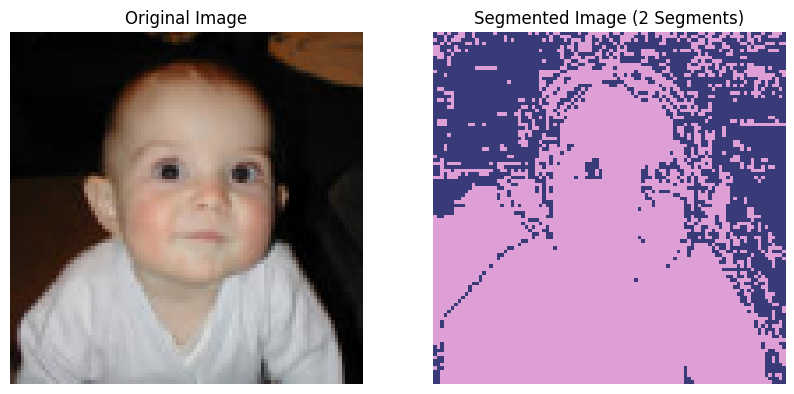

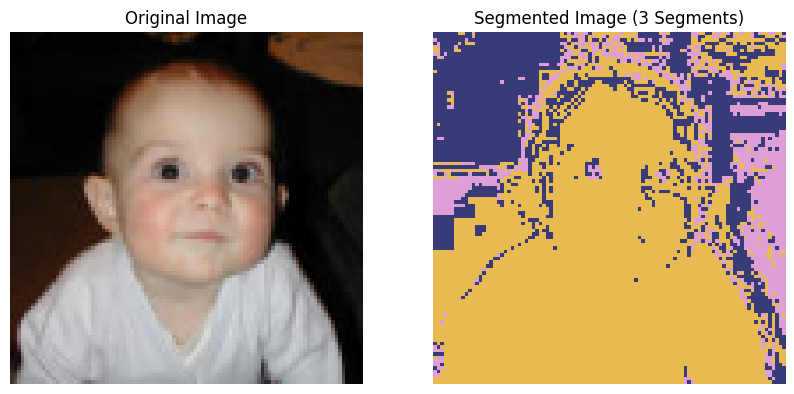

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to calculate Gaussian similarity
def gaussian_similarity(x1, x2, sigma=1.0):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * (sigma ** 2)))

# Build similarity matrix with Gaussian similarity
def build_similarity_matrix(image, sigma=1.0):
    rows, cols, _ = image.shape
    similarity_matrix = np.zeros((rows * cols, rows * cols))

    for i in range(rows):
        for j in range(cols):
            pixel1 = image[i, j]
            for k in range(rows):
                for l in range(cols):
                    pixel2 = image[k, l]
                    similarity_matrix[i * cols + j, k * cols + l] = gaussian_similarity(pixel1, pixel2, sigma)

    return similarity_matrix

# Normalized Cut implementation with multiple segments using eigenvectors and clustering
def normalized_cut(image, sigma=1.0, num_segments=2):
    rows, cols, _ = image.shape
    similarity_matrix = build_similarity_matrix(image, sigma)

    # Construct the degree matrix
    D = np.diag(similarity_matrix.sum(axis=1))

    # Compute the unnormalized Laplacian matrix
    L = D - similarity_matrix

    # Compute the eigenvalues and eigenvectors of the Laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Select the first 'num_segments' eigenvectors
    evecs = eigenvectors[:, 1:num_segments+1]

    # Normalize eigenvectors row-wise, and avoid NaN by replacing invalid values
    norms = np.linalg.norm(evecs, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero by setting zero norms to 1
    evecs_norm = evecs / norms

    # Replace NaN or Inf values with 0 (if any appear)
    evecs_norm = np.nan_to_num(evecs_norm)

    # Apply k-means clustering on the eigenvectors to divide into segments
    kmeans = KMeans(n_clusters=num_segments, random_state=42).fit(evecs_norm)
    segments = kmeans.labels_.reshape(rows, cols)

    return segments

# Function to load the image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

# Plot function for displaying the results
def plot_results(image, segments, num_segments):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segments, cmap='tab20b')  # Use a color map to visually separate segments
    plt.title(f"Segmented Image ({num_segments} Segments)")
    plt.axis('off')

    plt.show()

# Folder path where your images are stored
folder_path = '/content/drive/MyDrive/AIP Assignment/Assignment 2/1 test image'

# Load the images from the folder
def load_images_from_folder(folder_path):
    images = []
    filenames = os.listdir(folder_path)

    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append((filename, img))
    return images

# Load the images from the folder
images = load_images_from_folder(folder_path)

# Process each image
for filename, img in images:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image to 50x50 for testing
    image_resized = cv2.resize(img_rgb, (50, 50))  # Resize to 50x50 for faster processing

    # Apply Normalized Cut segmentation with 2 segments
    segments_2 = normalized_cut(image_resized, sigma=1.0, num_segments=2)

    # Apply Normalized Cut segmentation with 3 segments (more than 2 for at least one image)
    segments_3 = normalized_cut(image_resized, sigma=1.0, num_segments=3)

    # Plot the results for the current image
    plot_results(image_resized, segments_2, num_segments=2)
    plot_results(image_resized, segments_3, num_segments=3)

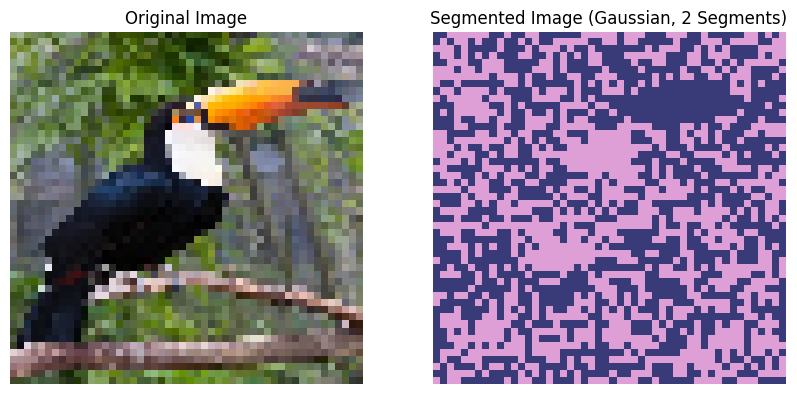

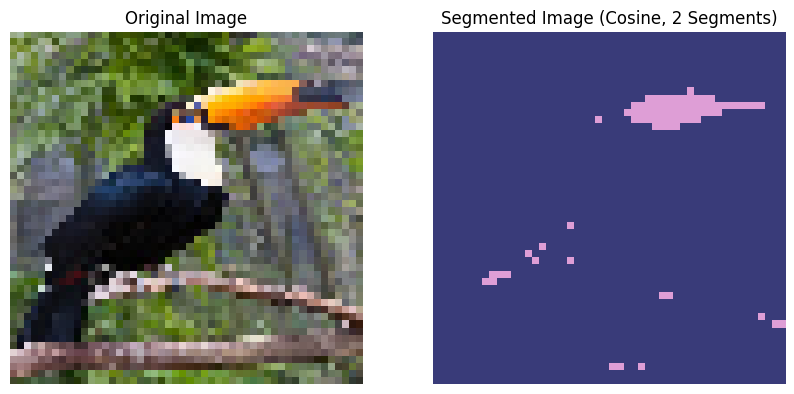

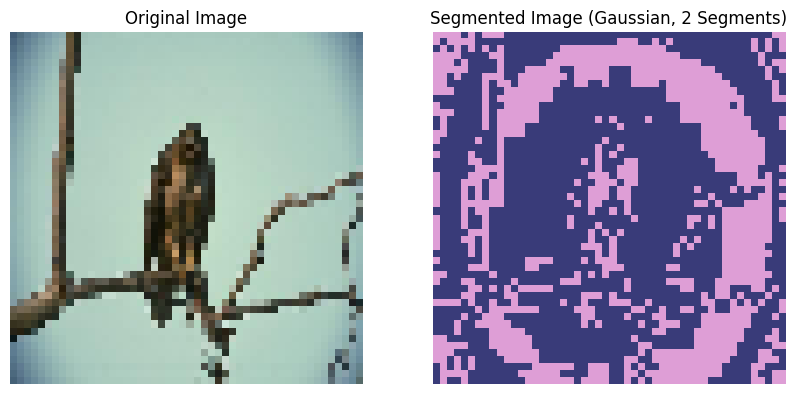

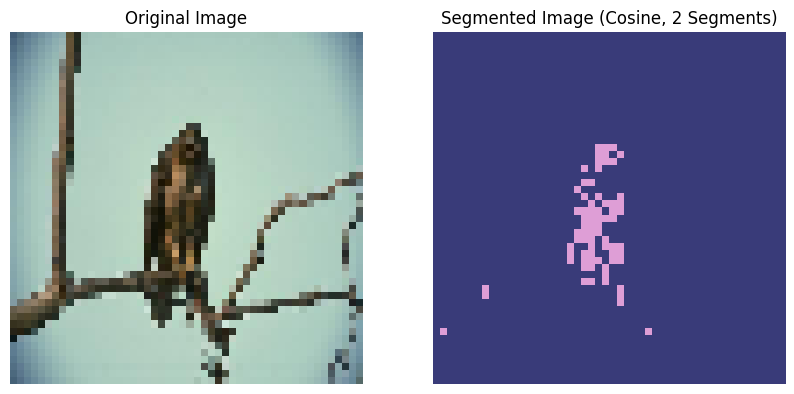

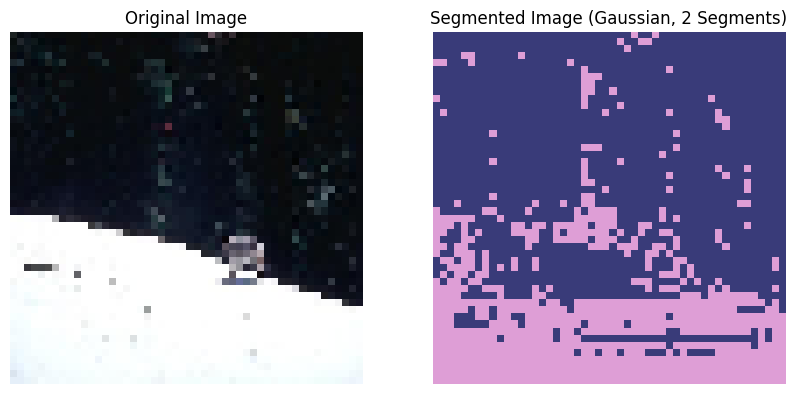

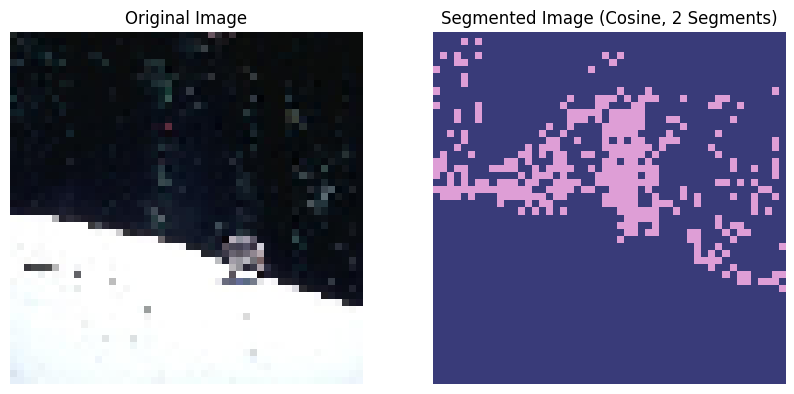

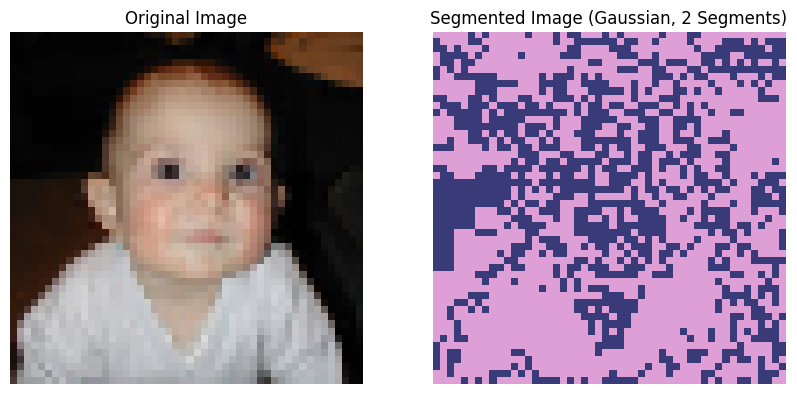

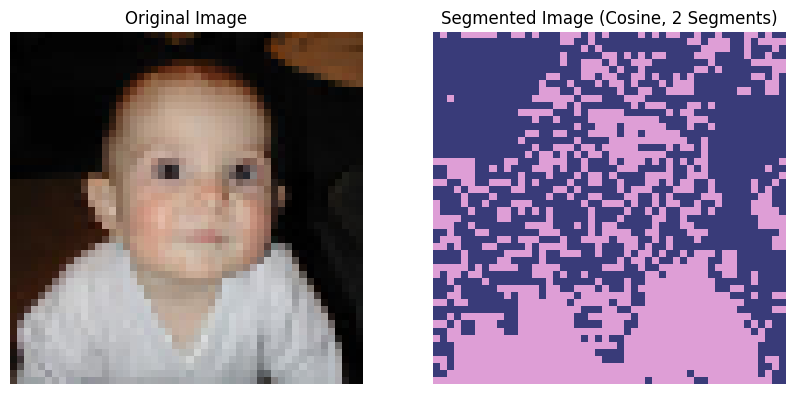

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

# Function to calculate Gaussian similarity
def gaussian_similarity(x1, x2, sigma=1.0):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * (sigma ** 2)))

# Function to calculate Cosine similarity between two vectors
def cosine_similarity_func(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

# Build similarity matrix with Gaussian similarity
def build_gaussian_similarity_matrix(image, sigma=1.0):
    rows, cols, _ = image.shape
    similarity_matrix = np.zeros((rows * cols, rows * cols))

    for i in range(rows):
        for j in range(cols):
            pixel1 = image[i, j]
            for k in range(rows):
                for l in range(cols):
                    pixel2 = image[k, l]
                    similarity_matrix[i * cols + j, k * cols + l] = gaussian_similarity(pixel1, pixel2, sigma)

    return similarity_matrix

# Build similarity matrix with Cosine similarity
def build_cosine_similarity_matrix(image):
    rows, cols, _ = image.shape
    # Flatten the image into a 2D matrix of pixels (each pixel is a vector)
    pixels = image.reshape((rows * cols, 3))
    similarity_matrix = cosine_similarity(pixels)
    return similarity_matrix

# Normalized Cut implementation using the similarity matrix (generalized)
def normalized_cut(image, similarity_matrix, num_segments=2):
    rows, cols, _ = image.shape

    # Construct the degree matrix
    D = np.diag(similarity_matrix.sum(axis=1))

    # Compute the unnormalized Laplacian matrix
    L = D - similarity_matrix

    # Compute the eigenvalues and eigenvectors of the Laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Select the first 'num_segments' eigenvectors
    evecs = eigenvectors[:, 1:num_segments+1]

    # Normalize eigenvectors row-wise
    norms = np.linalg.norm(evecs, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero by setting zero norms to 1
    evecs_norm = evecs / norms

    # Apply k-means clustering on the eigenvectors to divide into segments
    kmeans = KMeans(n_clusters=num_segments, random_state=42).fit(evecs_norm)
    segments = kmeans.labels_.reshape(rows, cols)

    return segments

# Function to load the image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

# Plot function for displaying the results
def plot_results(image, segments, num_segments, similarity_type):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segments, cmap='tab20b')  # Use a color map to visually separate segments
    plt.title(f"Segmented Image ({similarity_type}, {num_segments} Segments)")
    plt.axis('off')

    plt.show()

# Folder path where your images are stored
folder_path = '/content/drive/MyDrive/AIP Assignment/Assignment 2/1 test image'

# Load the images from the folder
def load_images_from_folder(folder_path):
    images = []
    filenames = os.listdir(folder_path)

    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append((filename, img))
    return images

# Load the images from the folder
images = load_images_from_folder(folder_path)

# Process each image for both similarity measures
for filename, img in images:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image to 50x50 for testing
    image_resized = cv2.resize(img_rgb, (50, 50))  # Resize to 50x50 for faster processing

    # Apply Normalized Cut segmentation with 2 segments using Gaussian similarity
    gaussian_similarity_matrix = build_gaussian_similarity_matrix(image_resized, sigma=1.0)
    segments_2_gaussian = normalized_cut(image_resized, gaussian_similarity_matrix, num_segments=2)

    # Apply Normalized Cut segmentation with 2 segments using Cosine similarity
    cosine_similarity_matrix = build_cosine_similarity_matrix(image_resized)
    segments_2_cosine = normalized_cut(image_resized, cosine_similarity_matrix, num_segments=2)

    # Plot the results for Gaussian similarity
    plot_results(image_resized, segments_2_gaussian, num_segments=2, similarity_type="Gaussian")

    # Plot the results for Cosine similarity
    plot_results(image_resized, segments_2_cosine, num_segments=2, similarity_type="Cosine")

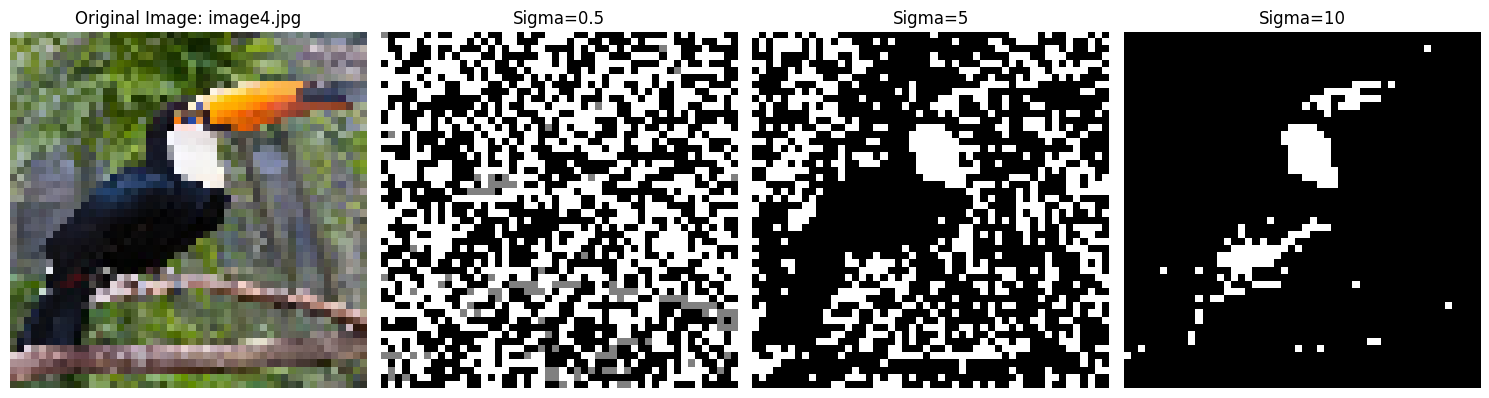

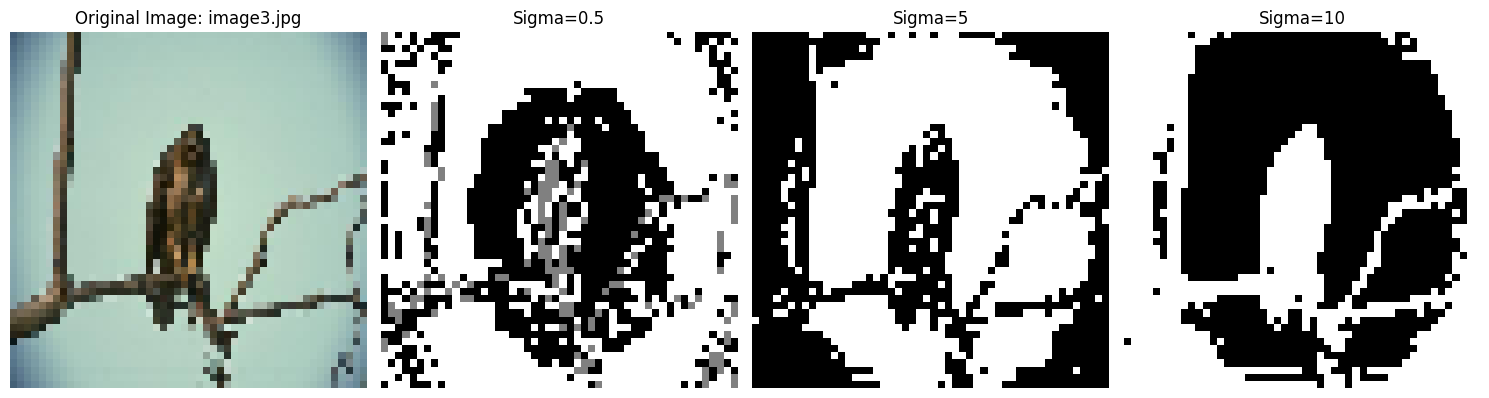

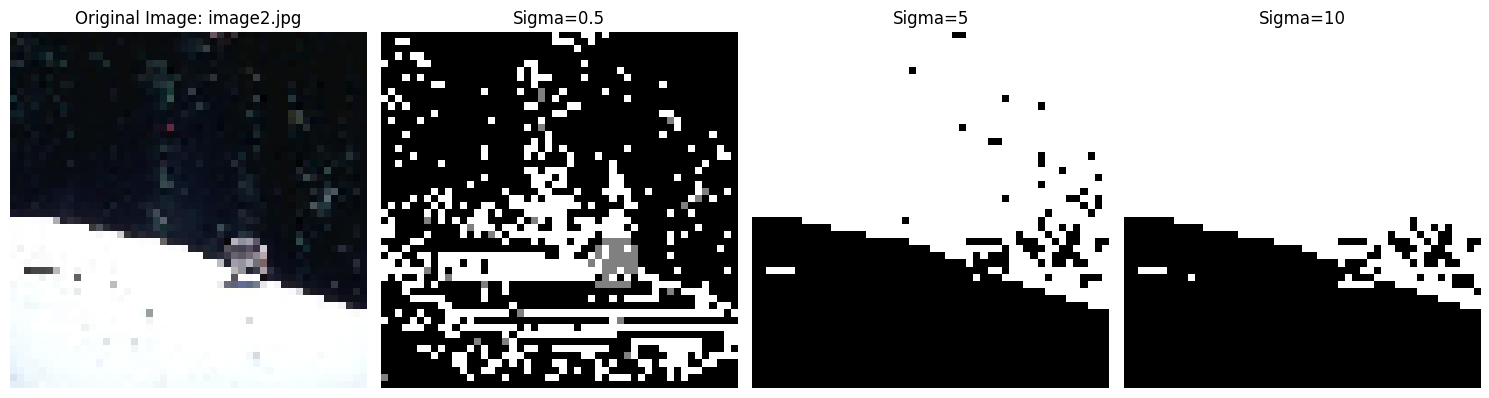

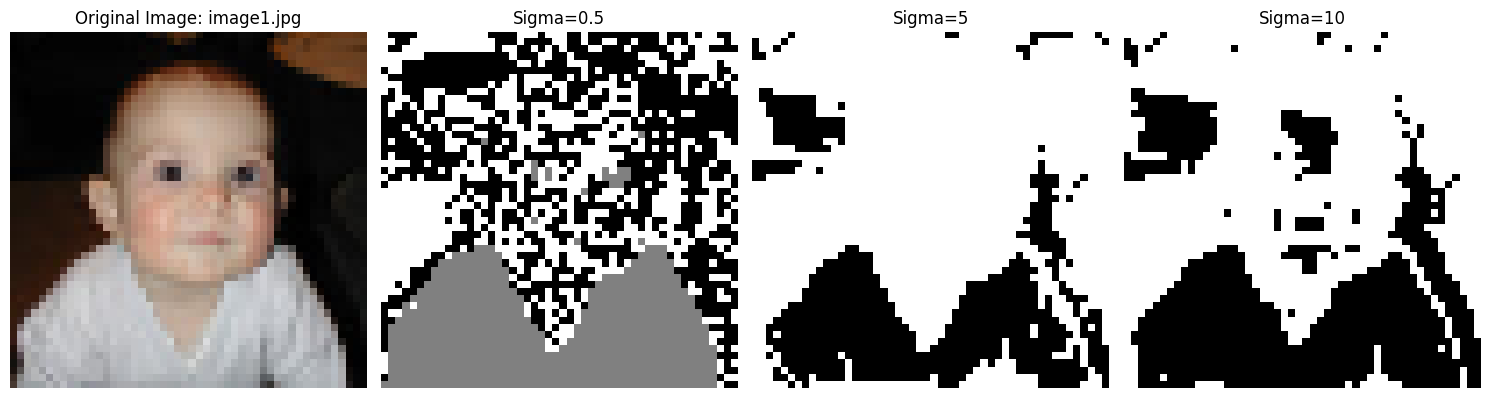

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate Gaussian similarity
def gaussian_similarity(x1, x2, sigma):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * (sigma ** 2)))

# Function to compute the similarity matrix using Gaussian similarity
def build_similarity_matrix(image, sigma=1.0):
    rows, cols, _ = image.shape
    similarity_matrix = np.zeros((rows * cols, rows * cols))

    for i in range(rows):
        for j in range(cols):
            pixel1 = image[i, j]
            for k in range(rows):
                for l in range(cols):
                    pixel2 = image[k, l]
                    similarity_matrix[i * cols + j, k * cols + l] = gaussian_similarity(pixel1, pixel2, sigma)

    return similarity_matrix

# Function to apply Normalized Cut segmentation using Gaussian similarity
def normalized_cut(image, sigma=1.0, num_segments=2):
    rows, cols, _ = image.shape
    similarity_matrix = build_similarity_matrix(image, sigma)

    # Construct the degree matrix
    D = np.diag(similarity_matrix.sum(axis=1))

    # Compute the unnormalized Laplacian matrix
    L = D - similarity_matrix

    # Compute the eigenvalues and eigenvectors of the Laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Select the second smallest eigenvector (this is the N-cut)
    evec = eigenvectors[:, 1]

    # Assign each pixel to a segment based on the sign of the eigenvector
    segments = np.sign(evec).reshape(rows, cols)

    return segments

# Load image function
def load_image(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return img_rgb

# Load images from your directory
folder_path = '/content/drive/MyDrive/AIP Assignment/Assignment 2/1 test image'
image_files = os.listdir(folder_path)

# Define sigma values for experimentation
sigma_values = [0.5,5,10]  # Different sigma values

# Loop through images
for filename in image_files:
    img_path = os.path.join(folder_path, filename)
    img_rgb = load_image(img_path)

    # Resize image for easier processing and comparison
    resized_img = cv2.resize(img_rgb, (50, 50))

    # Plot the original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(sigma_values) + 1, 1)
    plt.imshow(resized_img)
    plt.title(f"Original Image: {filename}")
    plt.axis('off')

    # Apply Normalized Cut segmentation with different sigma values
    for idx, sigma in enumerate(sigma_values):
        segments = normalized_cut(resized_img, sigma=sigma, num_segments=2)
        plt.subplot(1, len(sigma_values) + 1, idx + 2)
        plt.imshow(segments, cmap='gray')
        plt.title(f"Sigma={sigma}")
        plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()


Q2

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# Define paths to the VOC dataset folders
train_images_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/voc_2012_segmentation_data/train_images'
train_labels_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/voc_2012_segmentation_data/train_labels'
valid_images_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/voc_2012_segmentation_data/valid_images'
valid_labels_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/voc_2012_segmentation_data/valid_labels'

# Define image and mask transformations for preprocessing
image_transform = T.Compose([
    T.Resize((256, 256)),  # Resize images to 256x256
    T.ToTensor(),  # Convert image to Tensor
])

mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=Image.NEAREST),  # Resize mask with nearest neighbor interpolation
    lambda x: torch.as_tensor(np.array(x), dtype=torch.long)  # Convert mask to long tensor
])


class VOCDataset(Dataset):
    """
    Custom dataset for loading images and their corresponding segmentation masks.
    """

    def __init__(self, images_folder, masks_folder, image_transform=None, mask_transform=None):
        super().__init__()
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.image_names = sorted(os.listdir(images_folder))  # Assuming images are named consistently
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.images_folder, image_name)

        base_name = os.path.splitext(image_name)[0]  # Remove extension
        mask_name = base_name + ".png"  # Mask should have the same base name with .png extension
        mask_path = os.path.join(self.masks_folder, mask_name)

        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        mask = Image.open(mask_path)  # Open segmentation mask

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


# Create DataLoader for validation dataset
valid_dataset = VOCDataset(valid_images_folder, valid_labels_folder, image_transform=image_transform, mask_transform=mask_transform)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=2)

# Load pre-trained FCN ResNet50 model from PyTorch with VOC-specific weights
model = torchvision.models.segmentation.fcn_resnet50(weights=torchvision.models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set model to evaluation mode

# Pixel-wise Accuracy Calculation
def compute_pixel_accuracy(pred_mask, true_mask, ignore_index=255):
    mask = true_mask != ignore_index
    correct = (pred_mask == true_mask)[mask].sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0  # Return accuracy if there are valid pixels, else return 0

# Mean IoU Calculation
def compute_mean_iou(pred_mask, true_mask, num_classes=21, ignore_index=255):
    # Compute confusion matrix
    cm = confusion_matrix(true_mask.flatten().cpu().numpy(), pred_mask.flatten().cpu().numpy(), labels=[i for i in range(num_classes)])
    iou = np.zeros(num_classes)
    for i in range(num_classes):
        intersection = cm[i, i]
        union = cm[i, :].sum() + cm[:, i].sum() - intersection
        if union != 0:
            iou[i] = intersection / union
        else:
            iou[i] = np.nan  # Ignore classes with no pixels in both ground truth and prediction
    return np.nanmean(iou)  # Return mean IoU while ignoring NaNs

# Evaluation function that returns pixelwise accuracy and mean IoU
def evaluate(model, loader, device):
    model.eval()  # Set model to evaluation mode
    total_acc, total_iou, count = 0.0, 0.0, 0
    with torch.no_grad():  # No gradients needed for evaluation
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)['out']  # FCN outputs a dictionary with the 'out' key containing the predictions
            preds = torch.argmax(outputs, dim=1)  # Convert predictions to class labels (N, H, W)

            for i in range(preds.shape[0]):
                pred_mask = preds[i]
                true_mask = masks[i]
                acc = compute_pixel_accuracy(pred_mask, true_mask, ignore_index=255)
                miou = compute_mean_iou(pred_mask, true_mask, num_classes=21, ignore_index=255)
                total_acc += acc
                total_iou += miou
                count += 1

    return total_acc / count, total_iou / count  # Return average pixelwise accuracy and mean IoU

# Run evaluation on validation set
val_acc, val_miou = evaluate(model, valid_loader, device)
print(f"FCN-ResNet50 (pretrained) => Validation Accuracy: {val_acc:.4f}, Validation Mean IoU: {val_miou:.4f}")


FCN-ResNet50 (pretrained) => Validation Accuracy: 0.8887, Validation Mean IoU: 0.5866


In [ ]:
import os
from PIL import Image
import numpy as np

# Define paths to image and mask folders
image_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/segmentation_data/dataset/images'
mask_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/segmentation_data/dataset/masks'
output_image_folder = '/content/downsampled images'
output_mask_folder = '/content/downsampled mask'

# Create output folders if they don't exist
os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_mask_folder, exist_ok=True)

# Get a list of all image files
image_files = sorted(os.listdir(image_folder))  # Assuming files are named consistently
mask_files = sorted(os.listdir(mask_folder))

# Iterate over all images and masks
for image_file, mask_file in zip(image_files, mask_files):
    # Open the image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)

    # Open the corresponding mask
    mask_path = os.path.join(mask_folder, mask_file)
    mask = Image.open(mask_path)

    # Resize the image and mask to 224x224
    image_resized = image.resize((224, 224), Image.Resampling.LANCZOS)
    mask_resized = mask.resize((224, 224), Image.Resampling.NEAREST)
    # Save the resized image
    image_resized.save(os.path.join(output_image_folder, image_file))

    # Save the resized mask
    mask_resized.save(os.path.join(output_mask_folder, mask_file))

print("Resizing completed!")


Resizing completed!


In [ ]:
import os
import numpy as np
from PIL import Image

# Define paths to mask folder and output folder
mask_folder = '/content/downsampled mask'
output_mask_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/downsampled mask_classiied'

# Create output folder if it doesn't exist
os.makedirs(output_mask_folder, exist_ok=True)

# Mapping from RGB values to class labels
rgb_to_class = {
    (145, 96, 65): 0,  # Background
    (226, 213, 222): 1,  # Ground
    (0, 24, 253): 2,  # Bowler
    (176, 122, 83): 3,  # Batsmen
    (143, 223, 169): 4,  # Wicket Keeper
    (226, 9, 89): 5,  # Umpire
    (194, 254, 107): 6,  # Fielder
    (94, 141, 56): 7,  # Ball
    (30, 71, 42): 8   # Wicket
}

# Get a list of all mask files
mask_files = sorted(os.listdir(mask_folder))

# Function to convert RGB mask to class label
def convert_rgb_to_class_mask(mask_path):
    mask = Image.open(mask_path)
    mask = np.array(mask)

    # Create an empty array to hold class labels
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    # Iterate over the RGB mask and map to class label
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            rgb_value = tuple(mask[r, c])  # Get RGB value
            if rgb_value in rgb_to_class:
                class_mask[r, c] = rgb_to_class[rgb_value]
            else:
                class_mask[r, c] = 0  # If RGB value is not in mapping, set to 'Background'

    return class_mask

# Iterate over all masks
for mask_file in mask_files:
    # Get the full path of the mask image
    mask_path = os.path.join(mask_folder, mask_file)

    # Convert RGB mask to class label mask
    class_mask = convert_rgb_to_class_mask(mask_path)

    # Convert to Image and save the class mask
    class_mask_image = Image.fromarray(class_mask)
    class_mask_image.save(os.path.join(output_mask_folder, mask_file))

print("Mask conversion to class labels completed!")


Mask conversion to class labels completed!


In [ ]:

from sklearn.model_selection import train_test_split

# Define paths to image and mask folders
image_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/downsampled images'
mask_folder = '/content/drive/MyDrive/AIP Assignment/Assignment 2/downsampled mask_classiied'

# Get a list of all image files and mask files
image_files = sorted(os.listdir(image_folder))  # Assuming files are named consistently
mask_files = sorted(os.listdir(mask_folder))

# Initialize lists to hold image and mask data
X = []  # List for images
Y = []  # List for masks

# Load images and masks into X and Y
for image_file, mask_file in zip(image_files, mask_files):
    # Open the image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)
    image = np.array(image)  # Convert to numpy array

    # Open the mask
    mask_path = os.path.join(mask_folder, mask_file)
    mask = Image.open(mask_path)
    mask = np.array(mask)  # Convert to numpy array

    # Append the image and mask to X and Y respectively
    X.append(image)
    Y.append(mask)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print shapes of the resulting splits
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_train shape: (238, 224, 224, 3)
Y_train shape: (238, 224, 224)
X_test shape: (60, 224, 224, 3)
Y_test shape: (60, 224, 224)


array([[[226, 213, 222],
        [226, 213, 222],
        [226, 213, 222],
        ...,
        [145,  96,  65],
        [145,  96,  65],
        [145,  96,  65]],

       [[226, 213, 222],
        [226, 213, 222],
        [226, 213, 222],
        ...,
        [145,  96,  65],
        [145,  96,  65],
        [145,  96,  65]],

       [[226, 213, 222],
        [226, 213, 222],
        [226, 213, 222],
        ...,
        [145,  96,  65],
        [145,  96,  65],
        [145,  96,  65]],

       ...,

       [[226, 213, 222],
        [226, 213, 222],
        [226, 213, 222],
        ...,
        [145,  96,  65],
        [145,  96,  65],
        [145,  96,  65]],

       [[226, 213, 222],
        [226, 213, 222],
        [226, 213, 222],
        ...,
        [145,  96,  65],
        [145,  96,  65],
        [145,  96,  65]],

       [[226, 213, 222],
        [226, 213, 222],
        [226, 213, 222],
        ...,
        [145,  96,  65],
        [145,  96,  65],
        [145,  96,  65]]], dtype=uint8)
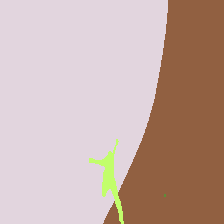

In [ ]:

class_to_rgb = {
    0: (145, 96, 65),   # Background
    1: (226, 213, 222),  # Ground
    2: (0, 24, 253),     # Bowler
    3: (176, 122, 83),   # Batsmen
    4: (143, 223, 169),  # Wicket Keeper
    5: (226, 9, 89),     # Umpire
    6: (194, 254, 107),  # Fielder
    7: (94, 141, 56),    # Ball
    8: (30, 71, 42)      # Wicket
}


def convert_class_to_rgb_mask(class_mask):
    height, width = class_mask.shape


    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)


    for r in range(height):
        for c in range(width):

            class_label = class_mask[r, c]

            if class_label in class_to_rgb:
                rgb_mask[r, c] = class_to_rgb[class_label]
            else:
                rgb_mask[r, c] = class_to_rgb[0]

    return rgb_mask


convert_class_to_rgb_mask(Y_test[0])


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Softmax, Add
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers


In [ ]:
def fcn32s(input_shape=(224, 224, 3), num_classes=9):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
      layer.trainable = False

    for layer in base_model.layers[-2:]:
      layer.trainable = True


    x = base_model.get_layer('block5_conv3').output


    x = Conv2D(num_classes, (1, 1), activation='relu', padding='same')(x)


    x = Conv2DTranspose(num_classes, kernel_size=(32, 32), strides=(16, 16), padding='same')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model


input_shape = (224, 224, 3)
num_classes = 9


model = fcn32s(input_shape, num_classes)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 9)           │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 224, 224, 9)         │          82,953 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,802,258 (56.47 MB)

 Trainable params: 2,447,378 (9.34 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [ ]:
model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 283s 16s/step - accuracy: 0.3934 - loss: 1.7872 - val_accuracy: 0.8474 - val_loss: 0.4514
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step - accuracy: 0.8307 - loss: 0.4617 - val_accuracy: 0.9026 - val_loss: 0.3189
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.9190 - loss: 0.2786 - val_accuracy: 0.9300 - val_loss: 0.2673
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.9437 - loss: 0.1964 - val_accuracy: 0.9284 - val_loss: 0.2810
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.9452 - loss: 0.1828 - val_accuracy: 0.9397 - val_loss: 0.2303
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.9495 - loss: 0.1699 - val_accuracy: 0.9349 - val_loss: 0.2544
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.9551 - loss: 0.1453 - val_accuracy: 0.9419 - val_loss: 0.2161
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.9582 - loss: 0.1312 - val_accuracy: 0.9411 - val_lo

In [ ]:
def fcn16(input_shape=(224, 224, 3), num_classes=9):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-2:]:
        layer.trainable = True

    block3_pool = base_model.get_layer('block3_pool').output
    block4_pool = base_model.get_layer('block4_pool').output
    block5_pool = base_model.get_layer('block5_pool').output
    block5_conv3 = base_model.get_layer('block5_conv3').output

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(block5_conv3)

    x = Conv2D(num_classes, (1, 1), padding='same', activation='relu')(x)

    x = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)

    block4_pool_upsampled = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(block4_pool)

    x = Add()([x, block4_pool_upsampled])

    x = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)

    block3_pool_upsampled = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(block3_pool)

    x = Add()([x, block3_pool_upsampled])

    x = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)

    x = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

input_shape = (224, 224, 3)
num_classes = 9
mod = fcn16(input_shape, num_classes)

mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mod.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 17,194,943 (65.59 MB)

 Trainable params: 4,840,063 (18.46 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [ ]:
mod.fit(X_train, Y_train, batch_size=16, epochs=30, validation_split=0.1)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 752ms/step - accuracy: 0.2255 - loss: 108.0357 - val_accuracy: 0.7161 - val_loss: 24.6420
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.7749 - loss: 24.2622 - val_accuracy: 0.8615 - val_loss: 13.7037
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.8673 - loss: 12.3476 - val_accuracy: 0.9093 - val_loss: 8.1298
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9260 - loss: 6.3691 - val_accuracy: 0.9225 - val_loss: 9.1743
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9411 - loss: 4.8746 - val_accuracy: 0.9176 - val_loss: 8.8438
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9377 - loss: 4.2400 - val_accuracy: 0.9280 - val_loss: 6.1210
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9459 - loss: 3.4537 - val_accuracy: 0.9267 - val_loss: 7.7825
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9472 - loss: 3.1449 - val_accu

In [ ]:
import numpy as np
random_indices = np.random.choice(X_test.shape[0], 15, replace=False)
X_test_selected = X_test[random_indices]
Y_test_selected = Y_test[random_indices]
print(f"Selected X_test shape: {X_test_selected.shape}")
print(f"Selected Y_test shape: {Y_test_selected.shape}")


Selected X_test shape: (15, 224, 224, 3)
Selected Y_test shape: (15, 224, 224)


In [ ]:
from sklearn.metrics import confusion_matrix

def compute_iou(y_true, y_pred, num_classes):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

    iou_per_class = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        IoU = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0
        iou_per_class.append(IoU)

    mean_iou = np.mean(iou_per_class)

    return iou_per_class, mean_iou

def calculate_pixelwise_accuracy_and_mean_iou(model, X_test, Y_test, num_classes):
    pixelwise_accuracies = []
    mean_ious = []

    for i in range(X_test.shape[0]):
        y_pred = model.predict(np.expand_dims(X_test[i], axis=0))

        y_pred_class = np.argmax(y_pred[0], axis=-1)

        y_true = Y_test[i]


        correct_pixels = np.sum(y_pred_class == y_true)
        total_pixels = np.prod(y_true.shape)
        pixelwise_accuracy = correct_pixels / total_pixels

        iou_per_class, mean_iou = compute_iou(y_true, y_pred_class, num_classes)


        pixelwise_accuracies.append(pixelwise_accuracy)
        mean_ious.append(mean_iou)

        print(f"Image {i+1} - Pixel-wise Accuracy: {pixelwise_accuracy:.4f}, Mean IoU: {mean_iou:.4f}")

    avg_pixelwise_accuracy = np.mean(pixelwise_accuracies)
    avg_mean_iou = np.mean(mean_ious)

    print(f"\nOverall Pixel-wise Accuracy: {avg_pixelwise_accuracy:.4f}")
    print(f"Overall Mean IoU: {avg_mean_iou:.4f}")

    return avg_pixelwise_accuracy, avg_mean_iou

num_classes = 9
avg_pixelwise_accuracy, avg_mean_iou = calculate_pixelwise_accuracy_and_mean_iou(model, X_test_selected, Y_test_selected, num_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 61s 61s/step
Image 1 - Pixel-wise Accuracy: 0.9601, Mean IoU: 0.1314
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image 2 - Pixel-wise Accuracy: 0.9544, Mean IoU: 0.1551
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image 3 - Pixel-wise Accuracy: 0.9591, Mean IoU: 0.1594
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image 4 - Pixel-wise Accuracy: 0.9823, Mean IoU: 0.2147
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image 5 - Pixel-wise Accuracy: 0.9656, Mean IoU: 0.1259
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image 6 - Pixel-wise Accuracy: 0.9892, Mean IoU: 0.2159
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image 7 - Pixel-wise Accuracy: 0.9704, Mean IoU: 0.2185
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image 8 - Pixel-wise Accuracy: 0.9913, Mean IoU: 0.1193
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image 9 - Pixel-wise Accuracy: 0.9195, Mean IoU: 0.1451
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image 10 - Pixel-wise Accuracy: 0.9406, Mean IoU: 0.1256
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image 11 - Pixel-wise Accuracy: 0.9699, M

In [ ]:
class_mapping = {
    0: (145, 96, 65),   # Background
    1: (226, 213, 222),  # Ground
    2: (0, 24, 253),     # Bowler
    3: (176, 122, 83),   # Batsmen
    4: (143, 223, 169),  # Wicket Keeper
    5: (226, 9, 89),     # Umpire
    6: (194, 254, 107),  # Fielder
    7: (94, 141, 56),    # Ball
    8: (30, 71, 42)      # Wicket
}


In [ ]:
def convert_class_mask_to_rgb(mask, class_mapping):
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            class_label = mask[r, c]
            if class_label in class_mapping:
                rgb_mask[r, c] = class_mapping[class_label]
            else:
                rgb_mask[r, c] = [0, 0, 0]

    return rgb_mask



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plt_segmentation_results(model, X_test, Y_test, class_mapping):
    fig, axes = plt.subplots(10, 3, figsize=(12, 40))

    for i in range(10):
        img = X_test[i]
        gt_mask = convert_class_mask_to_rgb(Y_test[i], class_mapping)

        pred_mask = model.predict(np.expand_dims(img, axis=0))
        pred_mask = np.argmax(pred_mask, axis=-1).squeeze()
        pred_mask_rgb = convert_class_mask_to_rgb(pred_mask, class_mapping)

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(gt_mask)
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask_rgb)
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
plt_segmentation_results(model, X_test_selected, Y_test_selected, class_mapping)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt_segmentation_results(mod, X_test_selected, Y_test_selected, class_mapping)

Output hidden; open in https://colab.research.google.com to view.